
# Семинар 8 (part1): GradCam

В рамках данного семинара рассмотрим подробно модуль lightning.pytorch. Обучим классификационную сеть на датасете СARS196, который является бенчмарком для задачи metric-learning: https://paperswithcode.com/sota/metric-learning-on-cars196

Данные можно найти по https://ai.stanford.edu/~jkrause/cars/car_dataset.html

А также рассмотрим библиотеку GradCam для интерпретации работы моделей компьютерного зрения:
repo - https://github.com/jacobgil/pytorch-grad-cam
paper - https://arxiv.org/abs/1610.02391

### Познакомимся с данными


In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [2]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [3]:
ADD_PATH = './cars_train'

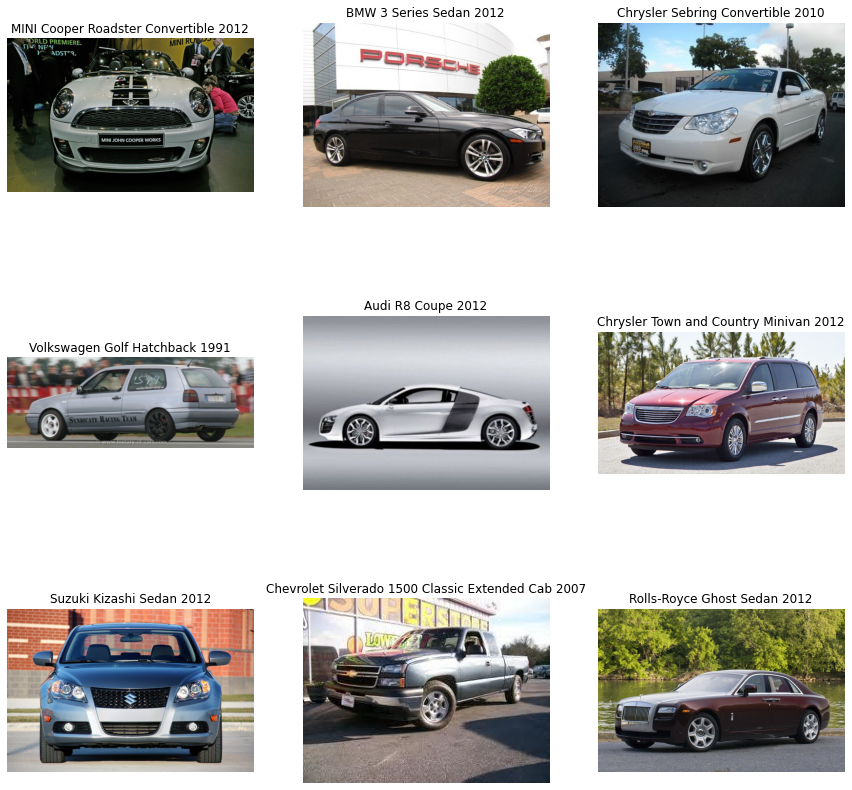

In [4]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

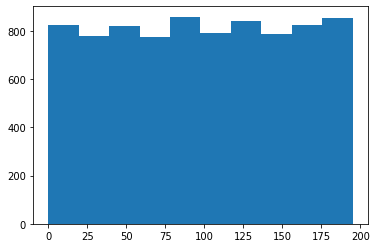

In [5]:
plt.hist(fname_to_class.values())
plt.show()

### Реализуем обертку для данных

In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [7]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, val_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

### Обучим модель

In [9]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from timm.scheduler import TanhLRScheduler
from lightning.pytorch.callbacks import LearningRateMonitor
from torchvision.models import resnet50

class CarClassifier(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size = 512):
        super().__init__()
        self.learning_rate = learning_rate
        
        self.class_dict = class_dict
        
        self.model = resnet50(pretrained=True)
        self.model.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=emb_size),
                            torch.nn.ReLU(inplace=False),
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
                        
        self.criterion = torch.nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        loss = self.criterion(preds, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        loss = self.criterion(preds, labels)
        self.log("validation_loss", loss, sync_dist=True)
        self.log("validation_accuracy", torch.sum(torch.argmax(preds, dim = 1) == labels).item() / torch.tensor(labels.shape).item(), sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        preds = [self.class_dict[i.argmax().item()] for i in preds]
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [10]:
# model
pl_model = CarClassifier(id_to_car, 3e-4)
checkpoint_callback = ModelCheckpoint(monitor='validation_accuracy',mode='max',  save_top_k=3)
last_checkpoint = ModelCheckpoint(mode='max', monitor='time_log', save_top_k=1)

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 20, accelerator=device, devices = 8, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 6 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6

Sanity Checking: 0it [00:00, ?it/s]

/home/.local/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"
/home/.local/lib/python3.7/site-packages/lightning/pytorch/trainer/trainer.py:1613: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

In [23]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    validation_accuracy    │    0.7303921580314636     │
│      validation_loss      │    1.0656883716583252     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 1.0656883716583252,
  'validation_accuracy': 0.7303921580314636}]

# GradCam

Данный фреймворк предназначен для интерпретации моделей компьютерного зрения на основе карт активации

![Drag Racing](images/cam-structure.png)

In [136]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

In [129]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def show_grad_cam(model, num_imgs):
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        filename, cl_id = list(fname_to_class.items())[im_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [model.layer4]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        pred = id_to_car[model(transformed_im).argmax().item()]
        ax[idx//cols][idx%cols].imshow(visualization)
        ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')


def show_diff_grad_methods(model, methods):
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.layer4]
            cam = method(model=model, target_layers=target_layers, use_cuda=True)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')


### посмотрим на различные методы

100%|██████████| 64/64 [00:03<00:00, 20.58it/s]


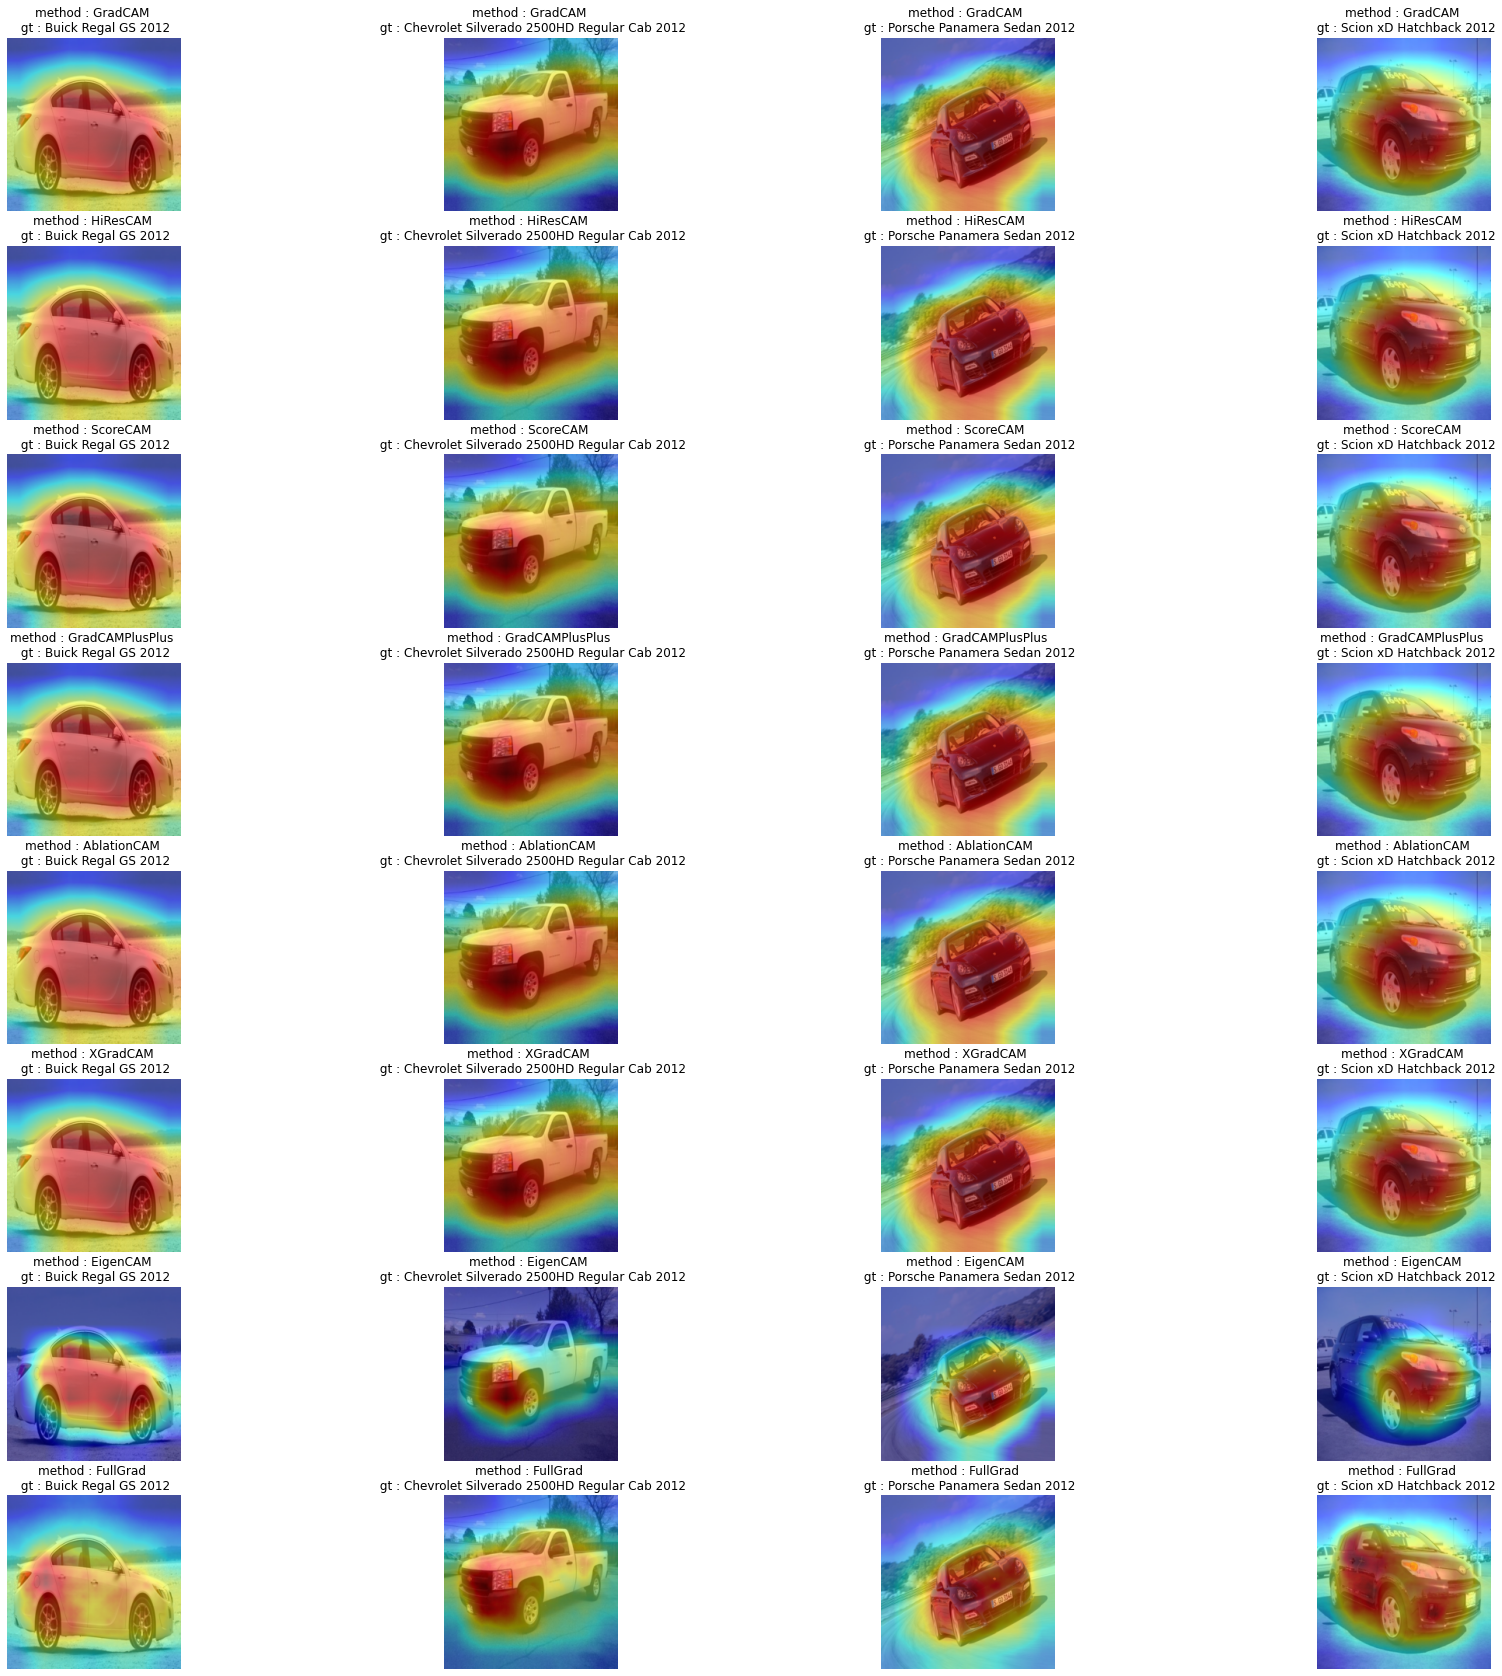

In [49]:
show_diff_grad_methods(pl_model.model, [ GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad])

### Cравним перфоманс различных моделей и посмотрим на ошибки

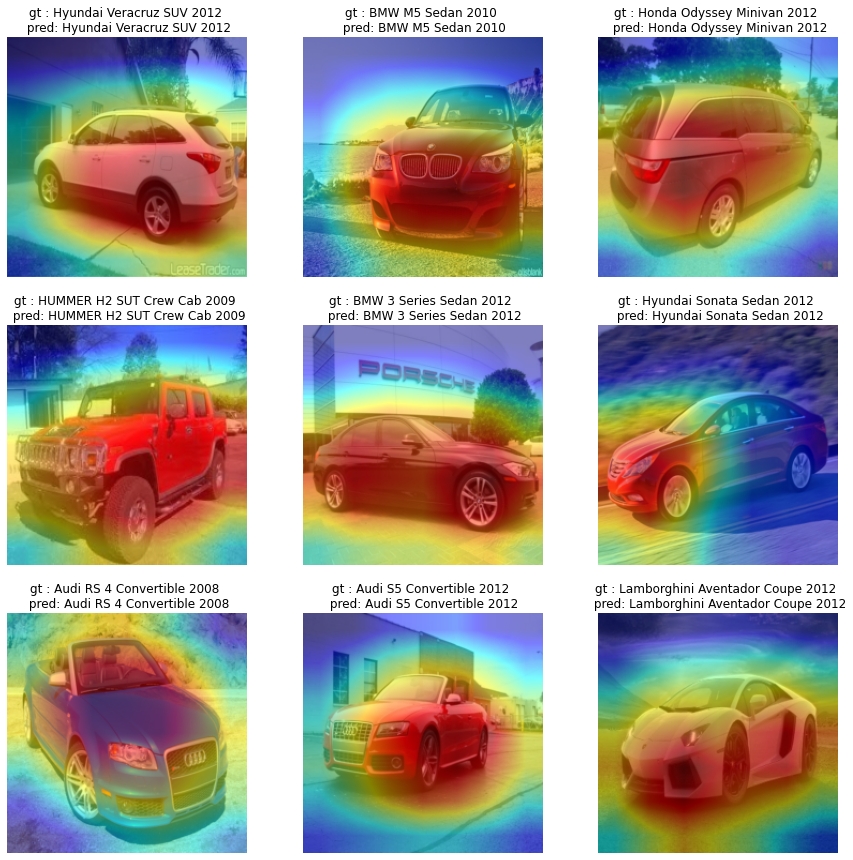

In [50]:
show_grad_cam(pl_model.model, num_imgs)

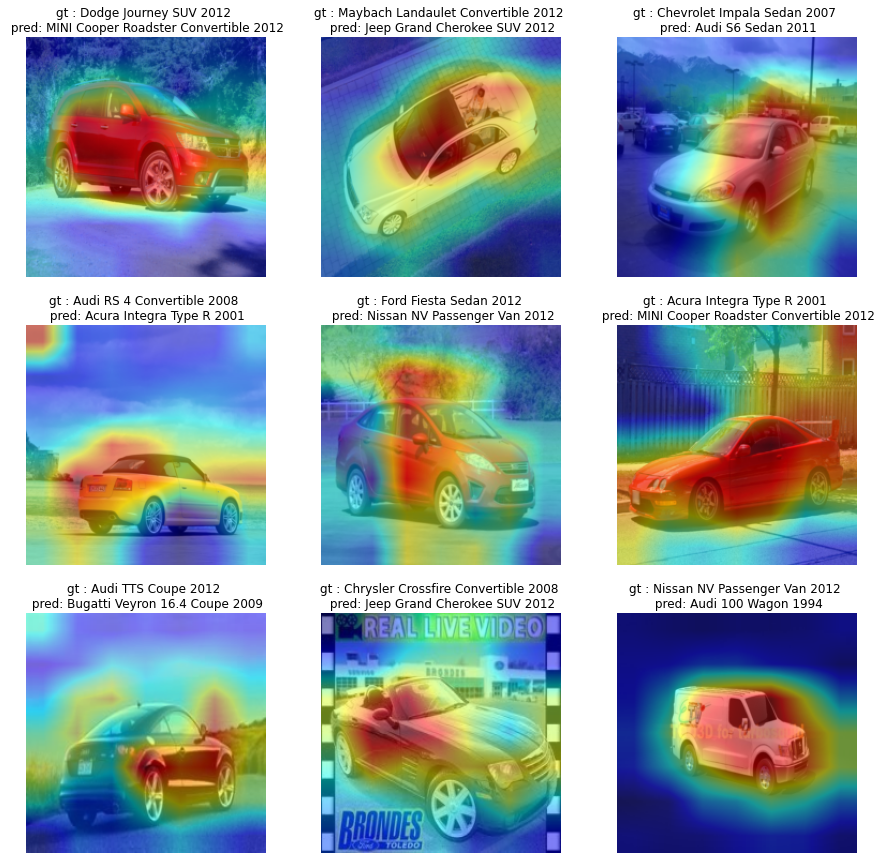

In [51]:
t = CarClassifier(id_to_car, 3e-4)
show_grad_cam(t.model, num_imgs)

In [32]:
t = resnet50(pretrained=False)
t.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=512),
                            torch.nn.ReLU(inplace=False),
                            torch.nn.Linear(in_features=512, out_features=len(id_to_car)))

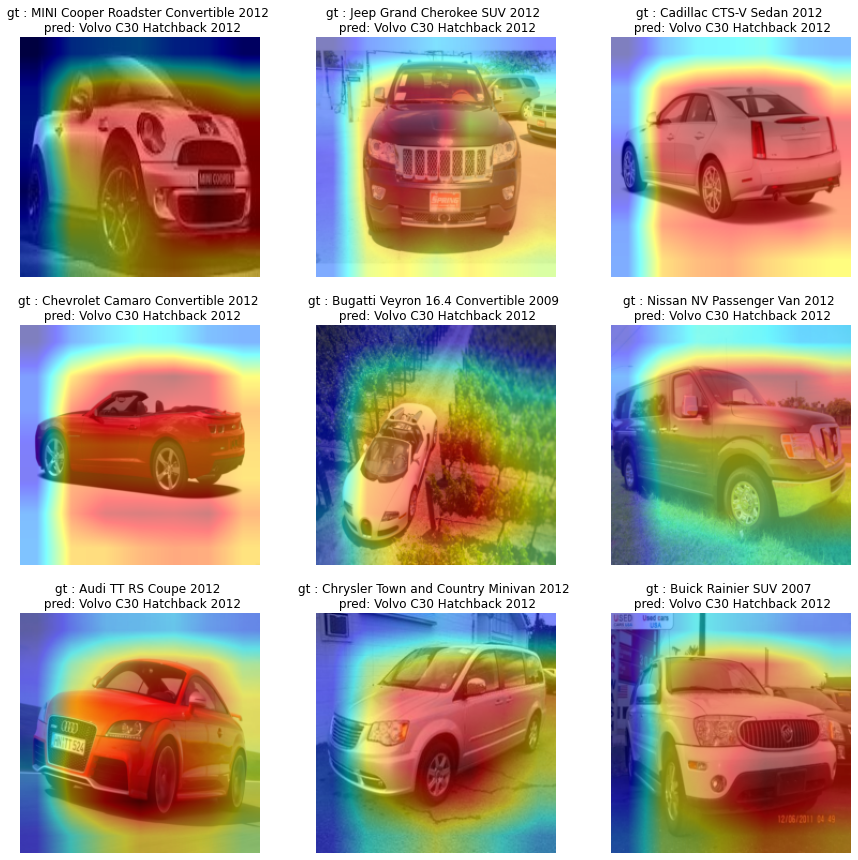

In [33]:
show_grad_cam(t, num_imgs)